# Import data 

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization

In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
%%time
X_df = pd.read_csv("drive/My Drive/para_comb_20p_sample.csv",header=None)
y_df = pd.read_csv("drive/My Drive/voltages_AP_30sek_sample.csv",header=None)

In [0]:
X = X_df.values
y = y_df.values

In [0]:
names = ['Cm','gL','gNa','EL','ENa','EK','gc','gkdr','gAHP','gC','gCa','ECa','p']

Next cell creates second order and interaction names for the features

In [0]:
from copy import copy
def sonames(names):
  all_names = copy(names)
  for i,name in enumerate(names):
    all_names.extend([name0+'^2' if name0==name else name+'*'+name0 for name0 in names[i:]])
  return all_names

snames = sonames(names)


# Import matlab structures

The structures are created using HPLSR.m and HPLSRpred.m in matlab. 

In [0]:
dir_path = "drive/My Drive/MatlabResults/PRag/"

In [0]:
!ls drive/My\ Drive/MatlabResults/PRag

In [0]:
from scipy import io
global_training = io.loadmat(dir_path+'global_PLSR_training.mat')
local_training =  io.loadmat(dir_path+'local_PLSR_training.mat')
PLSR_scores =  io.loadmat(dir_path+'PLSR_scores.mat')

In [0]:
gt_struct = global_training['global_train_model']
lt_struct = local_training['local_train_model']
sc_struct = PLSR_scores['train_model_ls']



In [0]:
gt_val = gt_struct[0,0]
lt_val = lt_struct[0,0]
sc_val = sc_struct[0,0]

In [0]:
LX = sc_val['LX']
SX = sc_val['SX']
LY = sc_val['LY']
SY = sc_val['SY']
W = sc_val['W']
LXgr = sc_val['LXgr']
SXgr = sc_val['SXgr']
LYgr = sc_val['LYgr']
SYgr = sc_val['SYgr']
Wgr = sc_val['Wgr']

R2 = gt_val['R2']
B = gt_val['B']
options = gt_val['options']
tf = gt_val['tf']
MSE = gt_val['MSE']
RMSEP = gt_val['RMSEP']
pctvar = gt_val['pctvar']
Ypred = gt_val['Ypred']
optPCs = gt_val['optPCs']

cluster_centers = lt_val['cluster_centers']
Bgr = lt_val['Bgr']
options = lt_val['options']
tf = lt_val['tf']
clusters = lt_val['clusters']
optPCsgr = lt_val['optPCsgr']
pctvargr = lt_val['pctvargr']
Ypredgr = lt_val['Ypredgr']
MSEgr = lt_val['MSEgr']
RMSEPgr = lt_val['RMSEPgr']

In [0]:
tf = tf.squeeze()
indexes = tf == 1

In [0]:
X_train = X[indexes,:]
X_test = X[~indexes,:]
y_train = y[indexes,:]
y_test = y[~indexes,:]

In [0]:
clusters = clusters.squeeze()

In [0]:
ag_names = ['Time to AP','Amplitude of AP','Width of AP']

In [0]:
headers = ['B0'] +  snames # Add B0 to names

# Plots

## Main regression coefficients

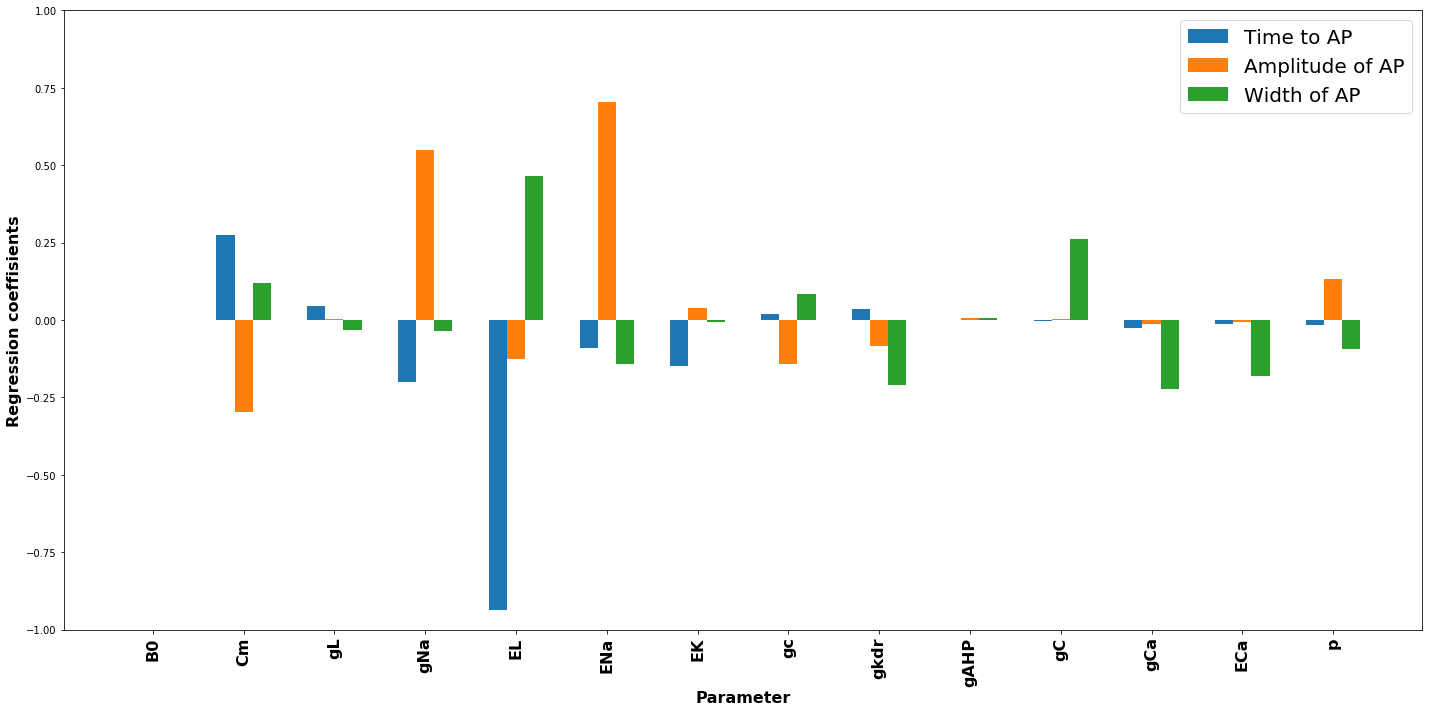

In [0]:

plt.figure(figsize=(20,10))

width=0.2


x = np.array([i for i in range(1,15)])
plt.bar(x-0.2,B[:14,0].T,width=width,label=ag_names[0]);
plt.bar(x,B[:14,1].T,width=width,label=ag_names[1]);
plt.bar(x+0.2,B[:14,2].T,width=width,label=ag_names[2]);



plt.ylim(-1,1)
plt.ylabel('Regression coeffisients',fontweight='bold',fontsize=16)

plt.xticks(x,headers[:14],fontweight='bold',fontsize=16,rotation=90);

plt.xlabel('Parameter',fontweight='bold',fontsize=16)

plt.legend(prop={'size': 20})
    


plt.tight_layout()
plt.savefig("drive/My Drive/Figures/HCPLSR/PRag_orginal")

## Significant second order and interaction regression coefficients

In [0]:
sign_indexes = []
sign_headers = []
for agt in range(3):
  sign_ind = []
  sign_head = []
  for i,b in enumerate(B[14:,agt]):
    if b > np.max(B[:14,agt])*0.05: # Significant if 5% of maximum value
      sign_ind.append(i+14)
      sign_head.append(headers[i+14])
  sign_indexes.append(sign_ind)
  sign_headers.append(sign_head)

In [0]:
new_sign_indexes = []
new_sign_headers = []
for i in range(3):
  for j,sh in enumerate(sign_indexes[i]):
    if sh not in new_sign_indexes:
      new_sign_indexes.append(sh)
      new_sign_headers.append(sign_headers[i][j])

In [0]:
len(new_sign_headers)

26

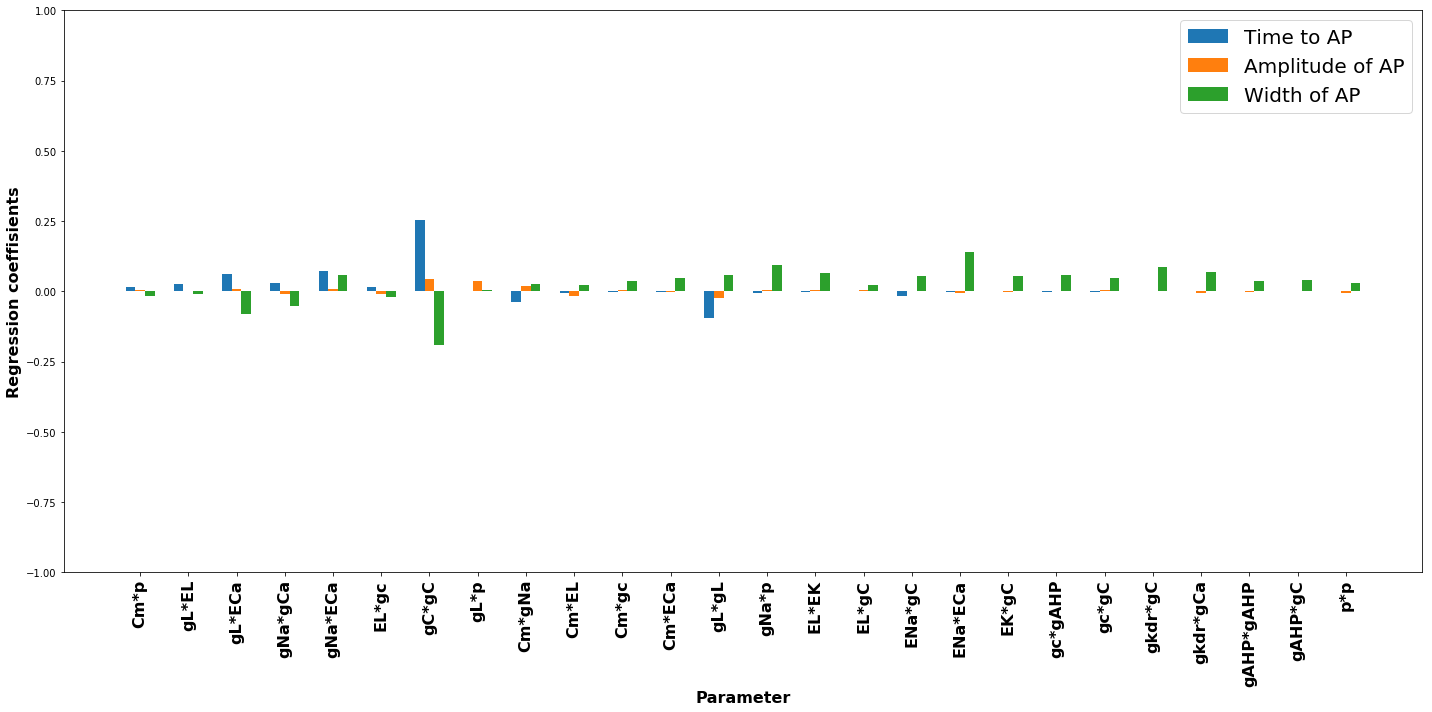

In [0]:

plt.figure(figsize=(20,10))

width=0.2


x = np.array([i for i in range(1,27)])
plt.bar(x-0.2,B[new_sign_indexes,0].T,width=width,label=ag_names[0]);
plt.bar(x,B[new_sign_indexes,1].T,width=width,label=ag_names[1]);
plt.bar(x+0.2,B[new_sign_indexes,2].T,width=width,label=ag_names[2]);



plt.ylim(-1,1)

plt.ylabel('Regression coeffisients',fontweight='bold',fontsize=16)

plt.xticks(x,new_sign_headers,fontweight='bold',fontsize=16,rotation=90);

plt.xlabel('Parameter',fontweight='bold',fontsize=16)

plt.legend(prop={'size': 20})
    


plt.tight_layout()
plt.savefig("drive/My Drive/Figures/HCPLSR/PRag_interaction")

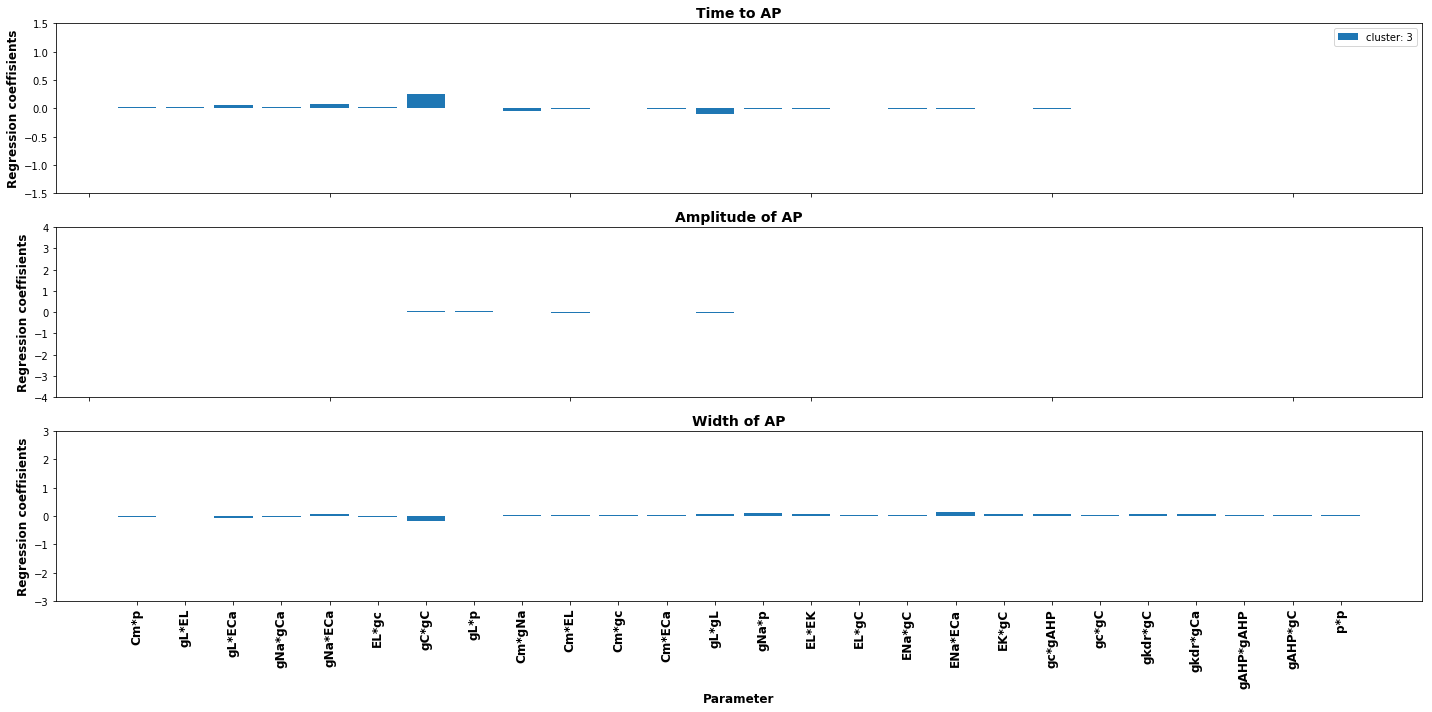

In [0]:
plt.figure(figsize=(20,10))
for n,agt in enumerate(ag_names):
  plt.subplot(3,1,n+1)
  plt.title(ag_names[n],fontweight='bold',fontsize=14)
  width=0.8


  x = np.array([i for i in range(1,27)])
  plt.bar(x    ,B[new_sign_indexes,n].T,width=width,label='cluster: 3');


  if n == 0:
    plt.ylim(-1.5,1.5)
    plt.ylabel('Regression coeffisients',fontweight='bold',fontsize=12)
    plt.tick_params(axis='x',labelbottom=False)
    plt.legend()
    
  elif n == 1:
    plt.ylim(-4,4)
    plt.ylabel('Regression coeffisients',fontweight='bold',fontsize=12)
    plt.tick_params(axis='x',labelbottom=False)
    
    
  else:
    plt.ylim(-3,3)
    plt.ylabel('Regression coeffisients',fontweight='bold',fontsize=12)
    plt.xticks(x,new_sign_headers,fontweight='bold',fontsize=12,rotation=90);
    plt.xlabel('Parameter',fontweight='bold',fontsize=12)
    
    
    


plt.tight_layout()
